In [ ]:
### Assumption
Since no dataset was provided, a realistic sample delivery dataset was generated and stored
in a MySQL database to demonstrate the complete end-to-end clustering workflow.

In [ ]:
!pip install pandas numpy scipy seaborn sqlalchemy mysql-connector-python

In [9]:
#Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns

from sqlalchemy import create_engine
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [33]:
#Creating a Sample Delivery Dataset in python
np.random.seed(42)

data = []
delivery_ids = range(1, 26)

for d_id in delivery_ids:
    for _ in range(np.random.randint(2, 5)):
        pickup = pd.Timestamp("2025-01-01") \
                 + pd.to_timedelta(np.random.randint(0, 14), unit="D") \
                 + pd.to_timedelta(np.random.randint(8, 20), unit="h")
        duration = np.random.randint(20, 150)  # minutes
        dropoff = pickup + pd.to_timedelta(duration, unit="m")
        data.append([d_id, pickup, dropoff])

sample_df = pd.DataFrame(
    data, columns=["delivery_id", "pickup_time", "dropoff_time"]
)

sample_df.head()

,delivery_id,pickup_time,dropoff_time
0,1,2025-01-04 18:00:00,2025-01-04 19:31:00
1,1,2025-01-13 12:00:00,2025-01-13 14:02:00
2,1,2025-01-10 10:00:00,2025-01-10 11:34:00
3,1,2025-01-11 15:00:00,2025-01-11 17:16:00
4,2,2025-01-06 12:00:00,2025-01-06 12:21:00


In [17]:
!pip install pymysql

  Using cached pymysql-1.1.2-py3-none-any.whl (45 kB)



[notice] A new release of pip available: 22.2.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
#Storing the Data into the MySQL
#if u want to run this give your mysql username and password
from urllib.parse import quote_plus
DB_USER = "database user name"
DB_PASSWORD = quote_plus("db password")
DB_HOST = "localhost"
DB_PORT = 3306
DB_NAME = "delivery_analysis"

engine = create_engine(
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

sample_df.to_sql(
    "delivery_logs",
    engine,
    if_exists="replace",
    index=False
)

78

In [22]:
#Extracting the Data from MySQL

df = pd.read_sql("SELECT * FROM delivery_logs", engine)
df.head(10)

,delivery_id,pickup_time,dropoff_time
0,1,2025-01-04 18:00:00,2025-01-04 19:31:00
1,1,2025-01-13 12:00:00,2025-01-13 14:02:00
2,1,2025-01-10 10:00:00,2025-01-10 11:34:00
3,1,2025-01-11 15:00:00,2025-01-11 17:16:00
4,2,2025-01-06 12:00:00,2025-01-06 12:21:00
5,2,2025-01-08 19:00:00,2025-01-08 19:57:00
6,2,2025-01-02 19:00:00,2025-01-02 19:40:00
7,2,2025-01-01 19:00:00,2025-01-01 20:17:00
8,3,2025-01-13 19:00:00,2025-01-13 20:48:00
9,3,2025-01-01 18:00:00,2025-01-01 19:18:00


In [23]:
#Feature Engineering

df["pickup_time"] = pd.to_datetime(df["pickup_time"])
df["dropoff_time"] = pd.to_datetime(df["dropoff_time"])

df["delivery_time_min"] = (
    df["dropoff_time"] - df["pickup_time"]
).dt.total_seconds() / 60

df["is_weekend"] = (df["pickup_time"].dt.weekday >= 5).astype(int)

df.head()

,delivery_id,pickup_time,dropoff_time,delivery_time_min,is_weekend
0,1,2025-01-04 18:00:00,2025-01-04 19:31:00,91.0,1
1,1,2025-01-13 12:00:00,2025-01-13 14:02:00,122.0,0
2,1,2025-01-10 10:00:00,2025-01-10 11:34:00,94.0,0
3,1,2025-01-11 15:00:00,2025-01-11 17:16:00,136.0,1
4,2,2025-01-06 12:00:00,2025-01-06 12:21:00,21.0,0


In [24]:
#Computing the Required Features ,avg time,variance and weekday vs weekend

features = df.groupby("delivery_id").agg({
    "delivery_time_min": ["mean", "var"],
    "is_weekend": "max"
})

features.columns = ["avg_time", "variance", "is_weekend"]
features = features.fillna(0)

features



,avg_time,variance,is_weekend
delivery_id,,,
1,110.750000,478.250000,1
2,48.750000,570.916667,0
3,73.333333,1385.333333,0
4,93.333333,892.333333,0
5,73.250000,3044.250000,1
6,47.500000,745.000000,1
7,51.666667,265.333333,1
8,136.500000,84.500000,1
9,107.500000,0.500000,0


In [25]:
#Data Normalize

scaled_features = (features - features.mean()) / features.std()

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [35.0, 35.0, 52.5, 52.5],
  [12.5, 12.5, 43.75, 43.75],
  [75.0, 75.0, 85.0, 85.0],
  [95.0, 95.0, 105.0, 105.0],
  [80.0, 80.0, 100.0, 100.0],
  [28.125, 28.125, 90.0, 90.0],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [115.0, 115.0, 132.5, 132.5],
  [175.0, 175.0, 185.0, 185.0],
  [165.0, 165.0, 180.0, 180.0],
  [155.0, 155.0, 172.5, 172.5],
  [205.0, 205.0, 215.0, 215.0],
  [195.0, 195.0, 210.0, 210.0],
  [163.75, 163.75, 202.5, 202.5],
  [235.0, 235.0, 245.0, 245.0],
  [225.0, 225.0, 240.0, 240.0],
  [183.125, 183.125, 232.5, 232.5],
  [123.75, 123.75, 207.8125, 207.8125],
  [59.0625, 59.0625, 165.78125, 165.78125]],
 'dcoord': [[0.0,
   np.float64(0.5252561078902872),
   np.float64(0.5252561078902872),
   0.0],
  [0.0,
   np.float64(0.9331424808171345),
   np.float64(0.9331424808171345),
   np.float64(0.5252561078902872)],
  [0.0, np.float

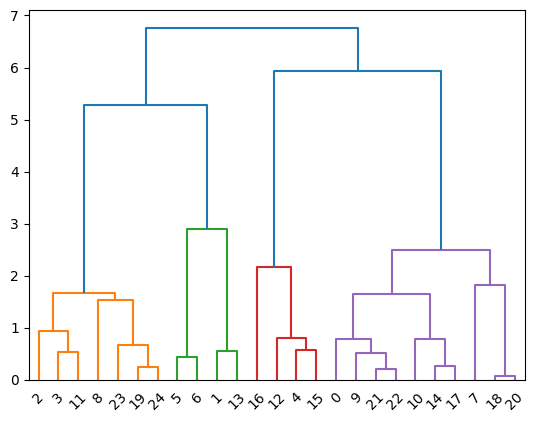

In [26]:
#Hierarchical Clustering and Dendrogram
linked = linkage(scaled_features, method="ward")
dendrogram(linked)

In [27]:
#Assign Clusters
features["cluster"] = fcluster(linked, t=3, criterion="maxclust")
features

,avg_time,variance,is_weekend,cluster
delivery_id,,,,
1,110.750000,478.250000,1,3
2,48.750000,570.916667,0,1
3,73.333333,1385.333333,0,1
4,93.333333,892.333333,0,1
5,73.250000,3044.250000,1,2
6,47.500000,745.000000,1,1
7,51.666667,265.333333,1,1
8,136.500000,84.500000,1,3
9,107.500000,0.500000,0,1


<Axes: xlabel='cluster', ylabel='avg_time'>

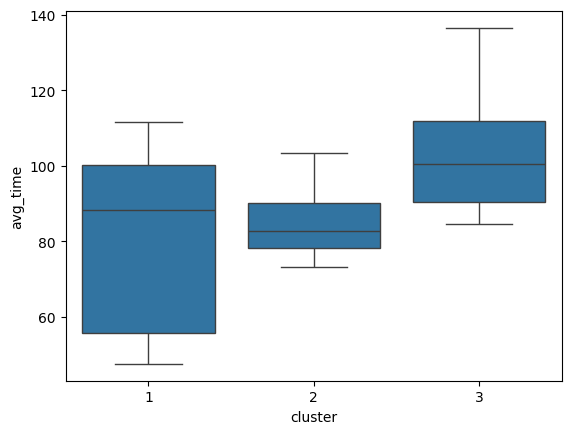

In [30]:
#Cluster Visualization using Seaborn
sns.boxplot(
    x="cluster",
    y="avg_time",
    data=features.reset_index()
)

In [31]:
#Cluster Summary
cluster_summary = features.groupby("cluster").mean()
cluster_summary

,avg_time,variance,is_weekend
cluster,,,
1,80.166667,931.000000,0.181818
2,85.500000,3680.791667,1.000000
3,102.583333,764.566667,1.000000


In [32]:
#Export Final CSV file
features.reset_index().to_csv(
    "delivery_cluster_mapping.csv",
    index=False
)

In [ ]:
### Insights
- One cluster represents deliveries with low average time and low variance, indicating consistent on-time deliveries.
- Another cluster shows moderate delays with higher variability.
- The final cluster highlights deliveries with high average time and high variance, pointing to inconsistent delivery performance.
